# Forward Rendering Polarized

This notebook demonstrates how to solve the Polarized Radiative Transfer using SHDOM and render stokes components and degree of polarization

The source Fortran code was created by Frank Evans and it is part of the SHDOM package: http://nit.colorado.edu/shdom.html

The python wrapper was created by Aviad Levis, Technion Inst. of Technology 2019: https://github.com/aviadlevis/pyshdom

In [1]:
"""
Imports necessary for this notebook
"""
import os 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

import shdom

'\nImports necessary for this notebook\n'

## Rayleigh Scattering

In [3]:
"""
Polarized Rayleigh scattering, of an atmosphere with optical depth of 2.
"""
tau = 0.2
nx, ny, nz = 3, 3, 3 

rayleigh = shdom.RayleighPolarized(wavelength=0.8)

bounding_box = shdom.BoundingBox(0.0, 0.0, 0.0, 1.0, 1.0, 1.0)
grid = shdom.Grid(bounding_box=bounding_box, nx=nx, ny=ny, nz=nz)

alb_data = np.full(shape=(nx, ny, nz), fill_value=1.0, dtype=np.float32)
ext_data = np.full(shape=(nx, ny, nz), fill_value=tau/nz, dtype=np.float32)
phase_data = np.tile(rayleigh.phase[:, :, np.newaxis, np.newaxis, np.newaxis], (1, 1, grid.nx, grid.ny, grid.nz))

extinction_a = shdom.GridData(grid, ext_data)
albedo_a = shdom.GridData(grid, alb_data)
phase_a = shdom.GridPhaseMatrix(grid, phase_data)

air = shdom.Medium()
air.set_optical_properties(extinction_a, albedo_a, phase_a)

In [4]:
"""
Define the numerical and scene parameters.

Solve the Polarized Radiative Transfer for the domain 
using SHDOM: SOLVE_RTE procedure (src/polarized/shdomsub1.f)
"""
numerical_params = shdom.NumericalParameters(deltam=False)
source = shdom.SolarSource(azimuth=0, zenith=180)
scene_params = shdom.SceneParameters(
    wavelength=0.8,
    source=source,
    boundary_conditions={'y': shdom.BoundaryCondition.periodic, 
                         'x': shdom.BoundaryCondition.periodic},
    surface=shdom.LambertianSurface(albedo=0.0)
) 
rte_solver = shdom.RteSolverPolarized(num_stokes=3, 
                                      scene_params=scene_params, 
                                      numerical_params=numerical_params)
rte_solver.init_medium(air)

rte_solver.solve(maxiter=100)

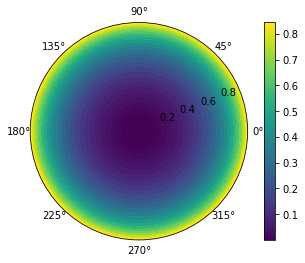

In [5]:
"""
Measure the reflected stokes vector at a single location over a hemisphere of directions.
Polar plot the Degree of Linear Polarization (DoLP) 
"""
camera = shdom.Camera(
    sensor=shdom.PolarizationSensor(),
    projection=shdom.HemisphericProjection(x=0.5, y=0.5, z=1.0, resolution=3)
)
dolp = camera.render(rte_solver)[1]

azimuth = camera.projection.phi.reshape(camera.projection.resolution, order='F')
radius = np.sqrt(1-camera.projection.mu**2).reshape(camera.projection.resolution, order='F')

%matplotlib inline
plt.subplot(projection='polar')
plt.pcolormesh(azimuth, radius, dolp)
plt.colorbar()

## Mie Scattering

In [2]:
"""
Generate a uniform infinite layer cloud with properties matching case A5 
Liquid Water Cloud from IPRT comparison project: 
https://arxiv.org/pdf/1901.01813.pdf
"""
class Args:
    nx=10
    ny=10
    nz=10
    extinction=5.0
    reff=10.0
    albedo=1.0
    domain_size=1.0
    mie_table_path='../mie_tables/Water_800nm_pol.scat'
    
args = Args()
generator =  shdom.Generate.HomogeneousPolarized(args)
atmosphere = shdom.Medium()
atmosphere.set_optical_properties(generator.extinction, generator.albedo, generator.phase)

numerical_params = shdom.NumericalParameters()
source = shdom.SolarSource(azimuth=180, zenith=130)
scene_params = shdom.SceneParameters(
    wavelength=0.8,
    source=source,
    boundary_conditions={'y': shdom.BoundaryCondition.periodic, 
                         'x': shdom.BoundaryCondition.periodic},
    surface=shdom.LambertianSurface(albedo=0.0)
) 
rte_solver = shdom.RteSolverPolarized(num_stokes=4, 
                                      scene_params=scene_params, 
                                      numerical_params=numerical_params)
rte_solver.init_medium(atmosphere)

print(rte_solver.info)

Reading mie table from file: ../mie_tables/Water_800nm_pol.scat
Done.
Scene Parameters: 
   Wavelength: [0.8 micron]
   Surface: [Lambertian, albedo: 0.0]
   Source: [Solar, flux: 1.0, azimuth: 180deg, zenith: 130deg]
   Boundary Conditions: [x:periodic, y:periodic]

Numerical Parameters: 
   acceleration_flag: True
   adapt_grid_factor: 5
   deltam: True
   cell_to_point_ratio: 1.5
   num_mu_bins: 8
   high_order_radiance: True
   max_total_mb: 10000.0
   solution_accuracy: 0.0001
   spherical_harmonics_accuracy: 0.01
   split_accuracy: 0.1
   num_phi_bins: 16
   num_sh_term_factor: 5



In [3]:
"""
Solve the Polarized Radiative Transfer for the domain using SHDOM: 
SOLVE_RTE procedure (src/polarized/shdomsub1.f).
"""
rte_solver.solve(maxiter=100)

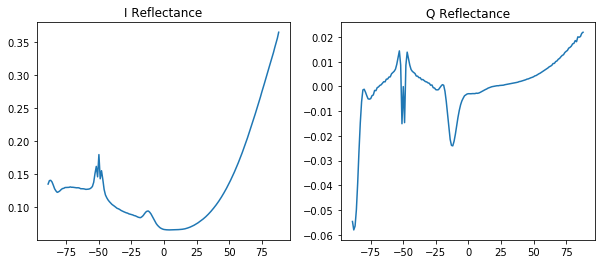

In [4]:
"""
Measure the reflected stokes vector along the solar principle plane.
Plot the reflectance I and Q components (Fig. 3 of  https://arxiv.org/pdf/1901.01813.pdf)
"""
camera = shdom.Camera(sensor=shdom.PolarizationSensor())
projection = shdom.PrincipalPlaneProjection(source=source, x=0.5, y=0.5, z=1.0)
camera.set_projection(projection)

stokes1 = camera.render(rte_solver)[0]

%matplotlib inline
f, axes = plt.subplots(1, 2, figsize=(10, 4));
axes[0].plot(projection.angles, stokes1[0,:]);
axes[0].set_title('I Reflectance');
axes[1].plot(projection.angles, stokes1[1,:]);
axes[1].set_title('Q Reflectance');

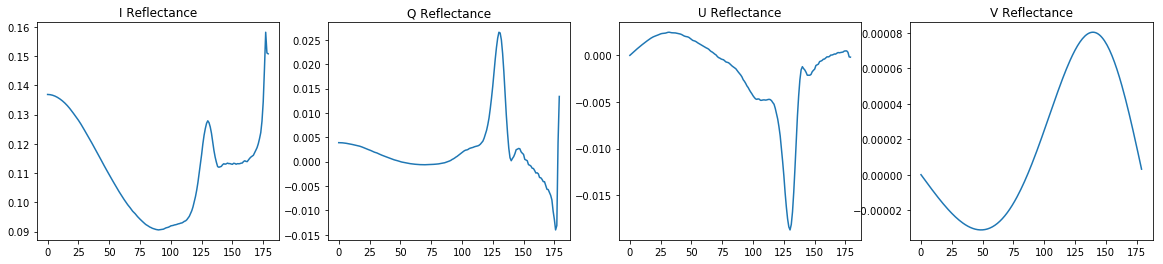

In [6]:
"""
Measure the reflected stokes vector along the solar almucantar plane.
Plot the reflectance I, Q, U, V components 
(Fig.4 of  https://arxiv.org/pdf/1901.01813.pdf)

Note: 
The azimuth of the plots has a 180deg difference
"""
projection = shdom.AlmucantarProjection(source=source, x=0.5, y=0.5, z=1.0, resolution=1.0)
camera.set_projection(projection) 
stokes = camera.render(rte_solver)[0]
azimuth = projection.azimuth-180

%matplotlib inline
f, axes = plt.subplots(1, 4, figsize=(20, 4));
axes[0].plot(azimuth, stokes[0,:])
axes[0].set_title('I Reflectance');
axes[1].plot(azimuth, stokes[1,:])
axes[1].set_title('Q Reflectance');
axes[2].plot(azimuth, stokes[2,:])
axes[2].set_title('U Reflectance');
axes[3].plot(azimuth, stokes[3,:])
axes[3].set_title('V Reflectance');

## Stratocumulus Cloud

In [3]:
"""
Load a Stratocumulus cloud field from SHDOM original distribution.
The atmosphere containts both Rayleigh and Mie scattering.
"""

# Mie scattering for water droplets
mie = shdom.MiePolarized()
mie.read_table(file_path='../mie_tables/Water_800nm_pol.scat')


# Generate a Microphysical medium
csv_path = '../synthetic_cloud_fields/shdom/les_stcu.txt'
microphysics = shdom.MicrophysicalMedium()
microphysics.load_from_csv(csv_path)

# Rayleigh scattering for air molecules
temperatures = np.array([283.64, 283.41, 283.17, 282.94, 282.72, 282.50, 282.29, 282.11, 
                         281.95, 281.82, 281.69, 281.58, 281.50, 281.71, 283.87, 286.190])
temp_grid = shdom.Grid(z=microphysics.grid.z)
temperature_profile = shdom.GridData(temp_grid, temperatures)
rayleigh = shdom.RayleighPolarized(wavelength=0.8)
rayleigh.init_temperature_profile(temperature_profile)

cloud = shdom.Medium()
air = shdom.AmbientMedium()
    
extinction_c, albedo_c, phase_c = mie.interpolate_scattering_field(microphysics.lwc, microphysics.reff, phase_type='Tabulated')
extinction_a, albedo_a, phase_a = rayleigh.get_scattering_field(temp_grid, phase_type='Tabulated')

cloud.set_optical_properties(extinction_c, albedo_c, phase_c)
air.set_optical_properties(extinction_a, albedo_a, phase_a)
    
atmosphere = cloud + air

'\nLoad a Stratocumulus cloud field from SHDOM original distribution.\nThe atmosphere containts both Rayleigh and Mie scattering.\n'

Reading mie table from file: ../mie_tables/Water_800nm_pol.scat
Done.


In [4]:
"""
Define the numerical and scene parameter and Solve the 
Polarized Radiative Transfer for the domain using SHDOM: SOLVE_RTE procedure 
(src/polarized/shdomsub1.f).
"""
numerical_params = shdom.NumericalParameters()
scene_params = shdom.SceneParameters(
    wavelength=0.8,
    source=shdom.SolarSource(azimuth=0, zenith=180),
    boundary_conditions={'y': shdom.BoundaryCondition.periodic, 
                         'x': shdom.BoundaryCondition.periodic},
)

rte_solver = shdom.RteSolverPolarized(3, scene_params, numerical_params)
rte_solver.init_medium(atmosphere)
rte_solver.solve(maxiter=100)

'\nDefine the numerical and scene parameter and Solve the \nPolarized Radiative Transfer for the domain using SHDOM: SOLVE_RTE procedure \n(src/polarized/shdomsub1.f).\n'

In [7]:
"""
Define a camera projection model and render the stokes componenets
"""
projection = shdom.OrthographicProjection(
    bounding_box=cloud.bounding_box, 
    x_resolution=0.02, 
    y_resolution=0.02, 
    azimuth=0.0, 
    zenith=0.0,
    altitude='TOA'
)

camera = shdom.Camera(shdom.PolarizationSensor(), projection)
    
stokes, dolp, aolp, docp = camera.render(rte_solver)

'\nDefine a camera projection model and render the stokes componenets\n'

'\nPlot the stokes components\n'

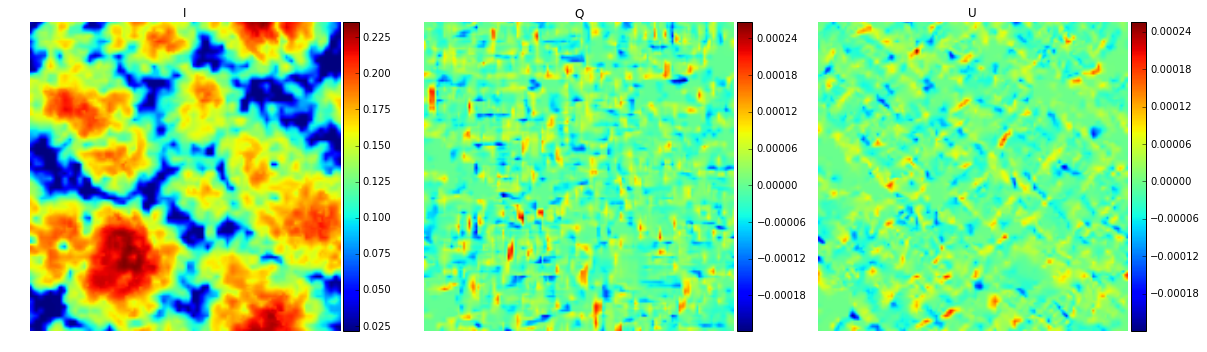

In [15]:
"""
Plot the stokes components
"""
%matplotlib inline

imgs = []
fig, axes = plt.subplots(1, 3, figsize=(20, 8));
imgs.append(axes[0].imshow(stokes[0,:]));
axes[0].set_title('I');
imgs.append(axes[1].imshow(stokes[1,:]));
axes[1].set_title('Q');
imgs.append(axes[2].imshow(stokes[2,:]));
axes[2].set_title('U');

for img, ax in zip(imgs, axes):
    divider = make_axes_locatable(ax);
    cax = divider.append_axes("right", size="5%", pad=0.05);
    img.set_cmap('jet');
    plt.colorbar(img, cax=cax);
    ax.set_axis_off();

'\nPlot the DoLP and AoLP\n'

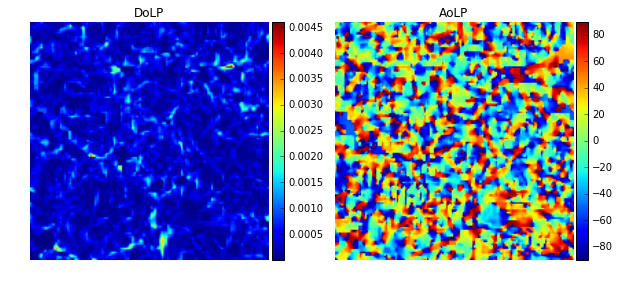

In [16]:
"""
Plot the DoLP and AoLP
"""
imgs = []
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
imgs.append(axes[0].imshow(dolp))
axes[0].set_title('DoLP');
imgs.append(axes[1].imshow(aolp))
axes[1].set_title('AoLP');

for img, ax in zip(imgs, axes):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    img.set_cmap('jet')
    plt.colorbar(img, cax=cax)
    ax.set_axis_off()

'\nSimulated cloudbow using a perspective camera\n'

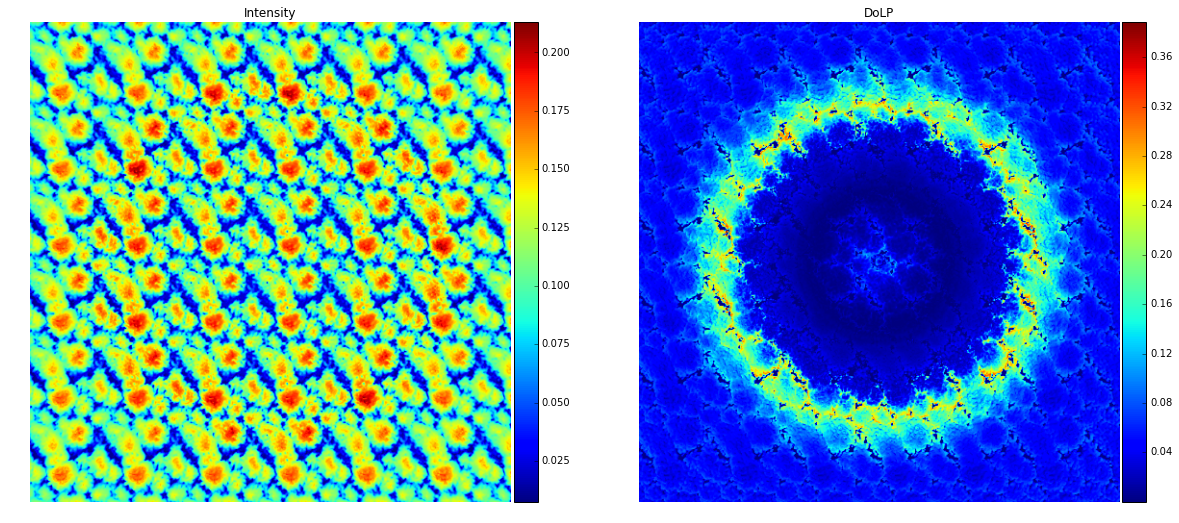

In [33]:
"""
Simulated cloudbow using a perspective camera
"""
projection = shdom.PerspectiveProjection(fov=100, nx=500, ny=500, x=1.75, y=1.75, z=10.0)
projection.look_at_transform(point=[1.75, 1.75, 0.0], up=[1.0, 0.0, 0.0])
camera.set_projection(projection)

stokes, dolp, aolp, docp = camera.render(rte_solver)

%matplotlib inline

imgs = []
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
imgs.append(axes[0].imshow(stokes[0]))
axes[0].set_title('Intensity');
imgs.append(axes[1].imshow(dolp))
axes[1].set_title('DoLP');

for img, ax in zip(imgs, axes):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    img.set_cmap('jet')
    plt.colorbar(img, cax=cax)
    ax.set_axis_off()